In [32]:
import numpy as np
import matplotlib.pyplot as plt
from dtaidistance import dtw, dtw_visualisation
from tslearn import metrics

In [30]:
%load_ext autoreload
%autoreload 2

from ksfdtw.lower_bounds import lb_shen
from ksfdtw.lower_bounds import lb_keogh_envelope, lb_keogh

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Sample sequences
np.random.seed(18)
q = np.sin(np.linspace(0, 4 * np.pi, 100))
c = q + np.random.normal(0, 0.4, size=100)

In [4]:
def lb_shen_argmin_q_of_cj(q, c, l=1, r=0.1):
    if isinstance(r, float):
        # print("r is a float.")
        minlen = min(len(a), len(b))
        r = int(minlen * r)
    elif isinstance(r, int):
        # Do something when r is an int
        # print("r is an integer.")
        # window=r
        pass
    else:
        raise ValueError("r must be either an integer or a float.")
    m = len(q)
    n = len(c)
    dist = lambda a, b: (a - b) ** 2

    window_contrib = []
    dist_total = 0
    # window_contrib.append((0, 0))
    dist_total += dist(q[0], c[0])
    window_contrib.append(q[0])  # Window for c_o

    for j in range(1, min(np.ceil(l * m), n - 1)):
        start = int(max(0, np.ceil(j / l) - r))
        end = int(min(np.ceil(j * l) + r, m - 1))
        # print(j, start, end)
        q_window = q[start : end + 1]
        # print("q_window ", q_window)
        argmin = np.argmin([dist(c[j], q_k) for q_k in q_window])  # q_k = q_argmin
        min_dist = 0
        min_dist = dist(c[j], q_window[argmin])
        # print(min_dist)
        # min_dist = np.min([dist(c[j], q_k) for q_k in q_window])
        # window_contrib.append((j, q_window[argmin]))
        window_contrib.append(q_window[argmin])
        dist_total += min_dist
    dist_total += dist(q[-1], c[-1])
    window_contrib.append(q[-1])
    return np.sqrt(dist_total), window_contrib

In [5]:
c

array([ 0.03177138,  1.0026734 ,  0.19719113,  0.43586965,  0.66327587,
        0.84226451,  1.09364041,  0.93384598,  0.71517075,  0.65126941,
        1.27708532,  1.15138489,  1.22871524,  0.55618624,  0.5808997 ,
        1.48320861,  1.1287409 ,  1.04746534,  1.58256832,  0.55063935,
        0.80760589,  0.23241579, -0.12516052, -0.18849036,  0.44846386,
       -0.24522573, -0.69817427, -0.18969495, -0.0429886 ,  0.03462658,
        0.36732166, -0.26153362, -1.1234475 , -0.83903975, -0.49146779,
       -1.18526014, -0.71877451, -0.58327665, -1.6944072 , -0.92434377,
       -0.4786674 , -0.61061931, -0.69212188, -0.7407006 ,  0.18440783,
       -0.55874809, -1.07104488, -0.49913415, -0.12978819,  0.07772442,
       -0.03683643,  0.22370246,  0.2439675 ,  0.77006215,  0.09313415,
        0.61324194,  0.16931217,  0.3666184 ,  1.03043741,  0.75691819,
        1.35984172,  1.01671829,  1.21366002,  1.47641133,  0.74147088,
        0.00589544,  0.263975  ,  0.29866598,  0.52813921,  0.12

In [14]:
dist = lb_shen(q, c, l=1, r=5)
# dist = lb_kim(q, c, r=5)
# dist = lb_kim_fl(q, c, r=5)
dist

np.float64(2.2637676038911785)

In [ ]:
def dtai_dtw(a, b, l=1, r=0.1):
    if isinstance(r, float):
        # print("r is a float.")
        minlen = min(len(a), len(b))
        window = int(minlen * r)
    elif isinstance(r, int):
        # Do something when r is an int
        # print("r is an integer.")
        window = r
    else:
        raise ValueError("r must be either an integer or a float.")
    return dtw.distance(a, b, window=window)

In [22]:
dtai_dtw(q, c, r=5)

3.7060581448719647

Test for $LB_{Keogh}$ from `tslearn`

In [24]:
# LB_Keogh
env_low, env_up = metrics.lb_envelope(q, radius=5)
metrics.lb_keogh(ts_query=c, envelope_candidate=(env_low, env_up))

np.float64(2.240514607517655)

In [25]:
metrics.lb_keogh(ts_query=c, ts_candidate=q, radius=5)

np.float64(2.240514607517655)

$LB_{Shen}$ lower bounds DTW.

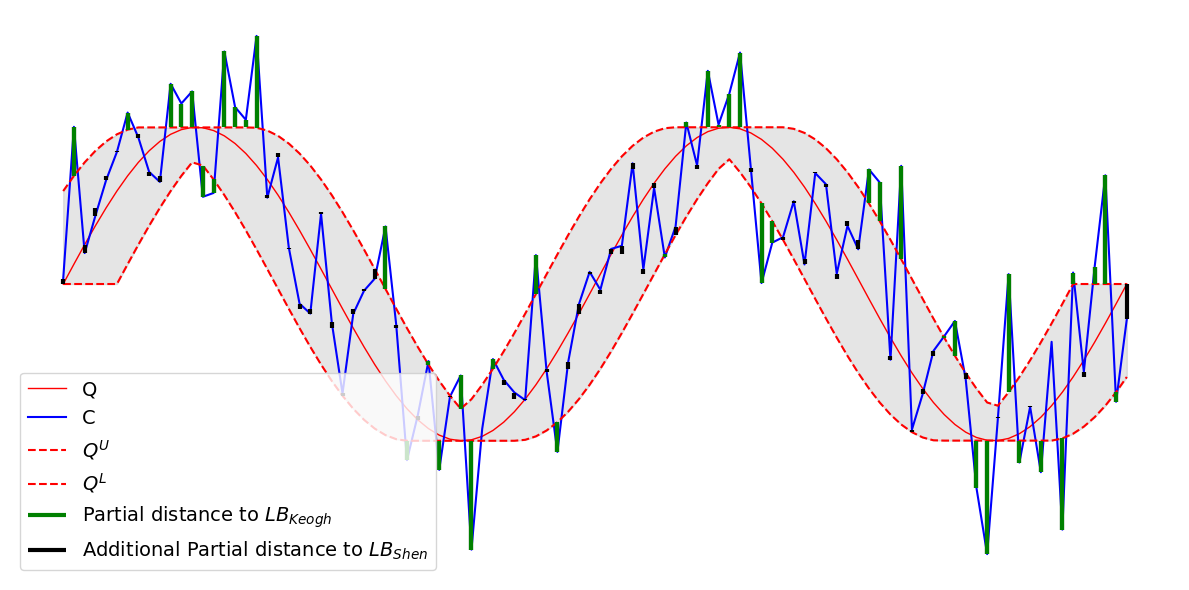

In [33]:
def plot_lb_keogh_full(q, c, radius):
    x = np.arange(len(q))
    lower, upper = lb_keogh_envelope(q, radius)
    lb = lb_keogh(q, c, radius)

    plt.figure(figsize=(12, 6))

    # Plot Q and C
    plt.plot(x, q, label="Q", color="red", linewidth=1)
    plt.plot(x, c, label="C", color="blue", linewidth=1.5)
    # Plot envelope
    plt.plot(x, upper, label="$Q^U$", linestyle="--", color="red", linewidth=1.5)
    plt.plot(x, lower, label="$Q^L$", linestyle="--", color="red", linewidth=1.5)
    plt.fill_between(x, lower, upper, color="gray", alpha=0.2)
    # Vertical bars
    # Old version
    # for i in x:
    #     if c[i] > upper[i]:
    #         plt.vlines(i, upper[i], c[i], color='black', linewidth=1.5)
    #     elif c[i] < lower[i]:
    #         plt.vlines(i, lower[i], c[i], color='black', linewidth=1.5)

    #     print(len(lower))
    lb_shen_dist, first_pair_smallest_elts_last_pair = lb_shen_argmin_q_of_cj(q, c, r=5)
    #     print(lb_shen_dist)
    #     print(len(np.array(first_pair_smallest_elts_last_pair)))
    plt.vlines(
        np.arange(len(q)),
        c,
        first_pair_smallest_elts_last_pair,
        label="Additional Partial distance to $LB_{Shen}$",
        color="black",
        linewidth=3.0,
    )
    # Elegant version
    plt.vlines(
        np.arange(len(q)),
        c,
        np.clip(c, lower, upper),
        label="Partial distance to $LB_{Keogh}$",
        color="green",
        linewidth=3.0,
    )

    # plt.title(f"LB_Keogh Visualization\nLower Bound = {lb:.4f}")
    # plt.xlabel("Time Index")
    # plt.ylabel("Value")

    # Get all legend handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()

    # Swap the last two (assuming they are in the expected order)
    handles[-2], handles[-1] = handles[-1], handles[-2]
    labels[-2], labels[-1] = labels[-1], labels[-2]

    plt.legend(handles=handles, labels=labels, loc="lower left", fontsize=14)
    # ax.legend(fontsize=25)
    # plt.legend(loc='upper right')
    # plt.grid(True)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("../figures/lb_keogh-lb_shen.pdf", format="pdf", bbox_inches="tight")
    plt.show()


plot_lb_keogh_full(q, c, radius=5)